# SUMMARY 

## approx 0 - 8 lice annotations per fish crop

## sorted lice category are
['ADULT_FEMALE', 'MOVING', 'SCOTTISH_ADULT_FEMALE', 'UNSURE']

In [3]:
from aquabyte.data_access_utils import RDSAccessUtils, S3AccessUtils
import json
import os
import  pandas as pd
from aquabyte.visualize import Visualizer
import matplotlib.patches as patches
from tqdm import tqdm

import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', 500)
%matplotlib inline
from utils import utils, data_prep


In [4]:
import cv2
from PIL import Image, ImageEnhance
import numpy as np
import matplotlib.pyplot as plt
from random import randint, seed

In [5]:
import importlib
importlib.reload(utils)
importlib.reload(data_prep)

<module 'utils.data_prep' from '/root/jane/cv_research/jane/lice_counting/utils/data_prep.py'>

In [38]:
SEED = 33
CROP_WIDTH = 512
CROP_HEIGHT = 512


LABEL_PATH = 'data/multi_lice_crop_labels'
IMAGE_PATH = 'data/multi_lice_crop_images'

# load annotation data

In [7]:
# docker-compose up 
# credentials = json.load(open(os.environ["DATA_WAREHOUSE_SQL_CREDENTIALS"]))

# docker run
credentials = json.load(open("/root/jane/cv_research/jane/deploy/data_warehouse_sql_credentials.json"))

rds_access_utils = RDSAccessUtils(credentials)

get_annotation_data = """
    SELECT 
        * 
    FROM 
        prod.crop_annotation 
    WHERE 
        (captured_at BETWEEN '2019-10-01' AND '2019-12-01') AND 
        (group_id = '56') AND
        (annotation_state_id IN (7)) AND
        (service_id = 1);
"""
annotation_data = rds_access_utils.extract_from_database(get_annotation_data)

In [14]:
annotation_data.head(3)

,service_id,pen_id,annotation_state_id,base_key,url_key,right_crop_url,left_crop_metadata,right_crop_metadata,camera_metadata,annotation,captured_at,ts_source_start,ts_source_end,ts,annotator_email,skip_reasons,group_id,left_crop_url,filter_reasons
0,1,56,7,https://aquabyte-crops.s3.eu-west-1.amazonaws.com/environment=production/site-id=39/pen-id=56/date=2019-10-01/hour=05/at=2019-10-01T05:13:42.783757000Z/,https://aquabyte-crops.s3.eu-west-1.amazonaws.com/environment=production/site-id=39/pen-id=56/date=2019-10-01/hour=05/at=2019-10-01T05:13:42.783757000Z/left_frame_crop_846_600_3122_1385.jpg,None,"{'width': 2307, 'height': 800, 'x_coord': 828, 'y_coord': 576, 'depth_mm': 484.16502232176987, 'crop_area': 1786660, 'quality_score': 0.9870305694416996, 'mean_luminance': 13.418134396023866, 'edge_detection_score': 0.16698476486852562, 'mean_green_luminance': 29.66566446109884}",None,"{'baseline': 0.10148368515391534, 'focalLength': 0.013854145853590238, 'pixelCountWidth': 4096, 'focalLengthPixel': 4015.694450316011, 'imageSensorWidth': 0.01412, 'pixelCountHeight': 3000, 'imageSensorHeight': 0.01035, 'stereoParametersUrl': 'http://aquabyte-stereo-parameters.s3.eu-west-1.amazonaws.com/L40029791_R40029780/2019-08-20T00:00:00Z_L40029791_R40029780_stereo-parameters.json'}",None,2019-10-01 05:13:42.783757+00:00,2019-10-01 07:23:57+00:00,None,2019-10-01 07:23:57.771000+00:00,gunnar@aquabyte.ai,None,56,https://aquabyte-crops.s3.eu-west-1.amazonaws.com/environment=production/site-id=39/pen-id=56/date=2019-10-01/hour=05/at=2019-10-01T05:13:42.783757000Z/left_frame_crop_846_600_3122_1385.jpg,None
1,1,56,7,https://aquabyte-crops.s3.eu-west-1.amazonaws.com/environment=production/site-id=39/pen-id=56/date=2019-10-01/hour=05/at=2019-10-01T05:14:53.250725000Z/,https://aquabyte-crops.s3.eu-west-1.amazonaws.com/environment=production/site-id=39/pen-id=56/date=2019-10-01/hour=05/at=2019-10-01T05:14:53.250725000Z/left_frame_crop_1286_524_3434_1555.jpg,None,"{'width': 2178, 'height': 1050, 'x_coord': 1274, 'y_coord': 498, 'depth_mm': 488.9474956776813, 'crop_area': 2214588, 'quality_score': 0.9831454731159667, 'mean_luminance': 20.04596520887858, 'edge_detection_score': 0.18689209911730761, 'mean_green_luminance': 36.247277113011066}",None,"{'baseline': 0.10148368515391534, 'focalLength': 0.013854145853590238, 'pixelCountWidth': 4096, 'focalLengthPixel': 4015.694450316011, 'imageSensorWidth': 0.01412, 'pixelCountHeight': 3000, 'imageSensorHeight': 0.01035, 'stereoParametersUrl': 'http://aquabyte-stereo-parameters.s3.eu-west-1.amazonaws.com/L40029791_R40029780/2019-08-20T00:00:00Z_L40029791_R40029780_stereo-parameters.json'}","[{'id': '37c09621-e422-11e9-a674-ad85428a0e40', 'category': 'MOVING', 'location': 'TOP', 'position': {'top': 177, 'left': 571, 'width': 23, 'height': 11}}, {'id': '37c09622-e422-11e9-a674-ad85428a0e40', 'category': 'MOVING', 'location': 'TOP', 'position': {'top': 178, 'left': 543, 'width': 26, 'height': 12}}]",2019-10-01 05:14:53.250725+00:00,2019-10-01 08:06:05+00:00,None,2019-10-01 08:06:06.372000+00:00,gunnar@aquabyte.ai,None,56,https://aquabyte-crops.s3.eu-west-1.amazonaws.com/environment=production/site-id=39/pen-id=56/date=2019-10-01/hour=05/at=2019-10-01T05:14:53.250725000Z/left_frame_crop_1286_524_3434_1555.jpg,None
2,1,56,7,https://aquabyte-crops.s3.eu-west-1.amazonaws.com/environment=production/site-id=39/pen-id=56/date=2019-10-01/hour=05/at=2019-10-01T05:15:12.635108000Z/,https://aquabyte-crops.s3.eu-west-1.amazonaws.com/environment=production/site-id=39/pen-id=56/date=2019-10-01/hour=05/at=2019-10-01T05:15:12.635108000Z/left_frame_crop_958_178_3274_1374.jpg,None,"{'width': 2348, 'height': 1216, 'x_coord': 941, 'y_coord': 149, 'depth_mm': 447.1005560185746, 'crop_area': 2769936, 'quality_score': 0.9999065913844286, 'mean_luminance': 17.375244770998318, 'edge_detection_score': 0.12959180284309815, 'mean_green_luminance': 38.21422710233998}",None,"{'baseline': 0.10148368515391534, 'focalLength': 0.013854145853590238, 'p

# Histogram of lice count in each fish crop

In [ ]:


lice_count = []
for _, sf in annotation_data.iterrows():
    if sf['annotation']:
        lice_count.append(len(sf['annotation']))
    else:
        lice_count.append(0)
        
_ = plt.hist(lice_count)  # arguments are passed to np.histogram
#_ = plt.hist(orientation, bins=20)
plt.title("Histogram of lice count")
plt.xlabel('number of louse')
plt.show()

# Bar chart of each lice category count

In [18]:
category_count = {}
for _, sf in annotation_data.iterrows():
    if sf['annotation']:
        for louse in sf['annotation']:
            sf_category = louse["category"]
            if category_count.get(sf_category):
                category_count[sf_category] += 1
            else:
                category_count[sf_category] = 1



In [29]:
lice_category = list(category_count.keys())
lice_category.sort()
counts = [category_count[name] for name in lice_category]

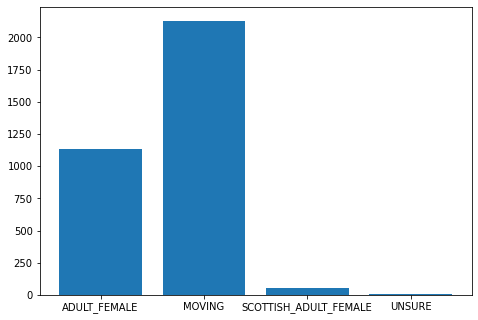

In [30]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(lice_category,counts)
plt.show("count of lice by category")

## sorted lice category are

['ADULT_FEMALE', 'MOVING', 'SCOTTISH_ADULT_FEMALE', 'UNSURE']


# fish crop with lice bbox

In [9]:
# s3_access_utils = S3AccessUtils('/root/data')

import boto3
from urllib.parse import urlparse


aws_credentials = json.load(open('/root/jane/cv_research/jane/deploy/aws_credentials.json'))
s3_client = boto3.client('s3', aws_access_key_id=aws_credentials["aws_access_key_id"],
aws_secret_access_key=aws_credentials["aws_secret_access_key"],
            region_name="eu-west-1")

def recursive_mkdir(dirname):
    if not os.path.exists(dirname):
        os.makedirs(dirname)
    return
    
def download_from_s3(bucket, key, custom_location=None):
    if custom_location:
        recursive_mkdir(os.path.dirname(custom_location))
        s3_client.download_file(bucket, key, custom_location)
    else:
        s3_base_dir = os.path.join('/root/data', 's3')
        f = os.path.join(s3_base_dir, bucket, key)
        if not os.path.exists(f):
            recursive_mkdir(os.path.dirname(f))
            s3_client.download_file(bucket, key, f)
        return f
    
def download_from_url(url):
    parsed_url = urlparse(url, allow_fragments=False)
    if parsed_url.netloc.startswith('s3'):
        url_components = parsed_url.path.lstrip('/').split('/')
        bucket, key = url_components[0], os.path.join(*url_components[1:])
    else:
        bucket = parsed_url.netloc.split('.')[0]
        key = parsed_url.path.lstrip('/')
    image_f = download_from_s3(bucket, key)
    return image_f, bucket, key

In [ ]:

for idx, sf in tqdm(annotation_data.iterrows()):
    if not sf['annotation']:
        continue
    if idx > 10:
        break
    left_image_f, bucket, left_image_key = download_from_url(sf["left_crop_url"])
    image_f = left_image_f 

    fig, ax = plt.subplots(figsize=(12, 12)) 
    image = plt.imread(image_f)


    alpha = 3 # Contrast control (1.0-3.0)
    beta = 20 # Brightness control (0-100)

    adjusted = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)



    ax.imshow(adjusted)
    
    for lice in sf['annotation']:
        lp = lice['position'] # only take the first female adult
        x, y, w, h = lp["left"], lp["top"], lp["width"], lp["height"]
        if lice['category'] == 'ADULT_FEMALE':
            ec = 'b'
        else:
            ec = 'r'
        rect = patches.Rectangle((x, y), w, h,linewidth=1,edgecolor=ec,facecolor='none')    
        ax.add_patch(rect)
plt.show()

# lice crop

In [ ]:
seed(SEED)
for idx, sf in tqdm(annotation_data.iterrows()):
    if not sf['annotation'] or idx < 10:
        continue
    if idx > 20:
        break
    left_image_f, bucket, left_image_key = download_from_url(sf["left_crop_url"])
    image_f = left_image_f 

    iw = sf['left_crop_metadata']['width']
    ih = sf['left_crop_metadata']['height']
    print(sf['annotation'])
    crops = data_prep.generate_crops(sf['annotation'], [iw, ih], [CROP_WIDTH, CROP_HEIGHT])

    print("num of crops {}".format(len(crops)))
    for crop in crops:
        
        fig, ax = plt.subplots(figsize=(10, 10))
        image = plt.imread(image_f)
        
        # crop lice image
        crop_left, crop_top = crop
        print("crop {} {}".format(crop_left, crop_top))
        cropped_image = image[crop_top:(crop_top + CROP_HEIGHT), crop_left:(crop_left + CROP_WIDTH)]
        
        # adjust image contrast and brightness
        alpha = 3 # Contrast control (1.0-3.0)
        beta = 20 # Brightness control (0-100)
        adjusted = cv2.convertScaleAbs(cropped_image, alpha=alpha, beta=beta)
        
        ax.imshow(adjusted)

    
        for lice in crops[crop]:
            lp = lice['position'] # only take the first female adult
            x, y, w, h = lp["left"], lp["top"], lp["width"], lp["height"]
            if lice['category'] == 'ADULT_FEMALE':
                ec = 'b'
            else:
                ec = 'r'
            crop_left_offset = x - crop_left
            crop_top_offset = y - crop_top
            rect = patches.Rectangle((crop_left_offset, crop_top_offset), w, h,linewidth=1,edgecolor=ec,facecolor='none')    
            ax.add_patch(rect)    

        plt.show()

In [39]:
seed(SEED)
for idx, sf in tqdm(annotation_data.iterrows()):
    if not sf['annotation']:
        continue

    left_image_f, bucket, left_image_key = download_from_url(sf["left_crop_url"])
    image_f = left_image_f 

    iw = sf['left_crop_metadata']['width']
    ih = sf['left_crop_metadata']['height']
    
    # randomly generate crops around lice
    crops = data_prep.generate_crops(sf['annotation'], [iw, ih], [CROP_WIDTH, CROP_HEIGHT])

    print("num of crops {}, out of {} lice".format(len(crops), len(sf['annotation'])))
    i = -1
    for crop in crops:
        i += 1
        image = plt.imread(image_f)
        
        # crop lice image
        crop_left, crop_top = crop
        # print("crop {} {}".format(crop_left, crop_top))
        cropped_image = image[crop_top:(crop_top + CROP_HEIGHT), crop_left:(crop_left + CROP_WIDTH)]
        
        # get file name
        start, end = "left_frame_crop_", ".jpg"
        s = sf["left_crop_url"]
        file_name = "left_" + s[s.find(start)+ len(start):s.find(end)]
        file_name += "_CROP_{}_{}".format(i, len(crops))    
        
        # save image
        data_prep.write_image(cropped_image, file_name, IMAGE_PATH)
        
        labels = []
        
        # save labels
        for lice in crops[crop]:
            lp = lice['position'] # only take the first female adult
            x, y, w, h = lp["left"], lp["top"], lp["width"], lp["height"]
            class_index = lice_category.index(lice['category'])
            
            crop_left_offset = x - crop_left
            crop_top_offset = y - crop_top            
            
            xywh = [crop_left_offset, crop_top_offset, w, h]
            bbox = utils.xywh2yolobbox(xywh, [CROP_WIDTH, CROP_HEIGHT])
            
            labels.append([class_index] + bbox)

            
        data_prep.write_labels(labels, file_name, LABEL_PATH)


7it [00:00,  9.46it/s]

num of crops 1, out of 2 lice
num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


10it [00:00, 11.34it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 2, out of 2 lice


16it [00:00, 13.81it/s]

num of crops 3, out of 3 lice
num of crops 1, out of 3 lice
num of crops 1, out of 2 lice


26it [00:00, 21.11it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


35it [00:01, 26.09it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 2, out of 2 lice


41it [00:01, 29.93it/s]

num of crops 1, out of 2 lice
num of crops 2, out of 4 lice
num of crops 2, out of 2 lice


49it [00:01, 23.78it/s]

num of crops 2, out of 2 lice
num of crops 1, out of 1 lice
num of crops 1, out of 2 lice
num of crops 1, out of 2 lice


52it [00:01, 21.16it/s]

num of crops 4, out of 6 lice
num of crops 2, out of 2 lice


61it [00:02, 24.61it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 2, out of 2 lice
num of crops 1, out of 1 lice


64it [00:02, 23.55it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 1, out of 2 lice
num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


85it [00:02, 32.99it/s]

num of crops 1, out of 1 lice
num of crops 2, out of 2 lice
num of crops 2, out of 3 lice


96it [00:02, 37.76it/s]

num of crops 1, out of 2 lice
num of crops 1, out of 1 lice
num of crops 2, out of 2 lice
num of crops 2, out of 2 lice


102it [00:02, 42.00it/s]

num of crops 1, out of 1 lice


108it [00:05,  8.41it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


112it [00:05,  8.37it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


115it [00:05,  7.62it/s]

num of crops 1, out of 1 lice


118it [00:06,  7.25it/s]

num of crops 1, out of 1 lice


120it [00:06,  6.05it/s]

num of crops 1, out of 1 lice


122it [00:07,  4.87it/s]

num of crops 1, out of 1 lice


124it [00:08,  4.19it/s]

num of crops 1, out of 1 lice


125it [00:08,  3.02it/s]

num of crops 1, out of 1 lice


126it [00:09,  2.68it/s]

num of crops 1, out of 1 lice


131it [00:09,  3.47it/s]

num of crops 1, out of 2 lice
num of crops 2, out of 2 lice
num of crops 1, out of 1 lice


135it [00:10,  4.13it/s]

num of crops 1, out of 1 lice
num of crops 3, out of 3 lice
num of crops 1, out of 1 lice


139it [00:10,  4.90it/s]

num of crops 1, out of 2 lice
num of crops 2, out of 2 lice


146it [00:11,  7.06it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


148it [00:12,  4.37it/s]

num of crops 1, out of 1 lice


167it [00:12,  7.95it/s]

num of crops 1, out of 2 lice
num of crops 1, out of 3 lice
num of crops 1, out of 1 lice
num of crops 2, out of 2 lice


173it [00:12, 10.62it/s]

num of crops 1, out of 3 lice
num of crops 1, out of 2 lice


177it [00:14,  6.13it/s]

num of crops 1, out of 2 lice


180it [00:14,  6.34it/s]

num of crops 1, out of 1 lice


183it [00:15,  6.50it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


186it [00:15,  6.44it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


188it [00:16,  4.15it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


201it [00:17,  5.38it/s]

num of crops 1, out of 1 lice


204it [00:17,  5.84it/s]

num of crops 1, out of 1 lice


206it [00:18,  4.80it/s]

num of crops 1, out of 1 lice


211it [00:18,  6.33it/s]

num of crops 1, out of 1 lice
num of crops 2, out of 3 lice
num of crops 1, out of 1 lice


213it [00:19,  5.10it/s]

num of crops 1, out of 1 lice


225it [00:20,  8.00it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


230it [00:20,  8.15it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


238it [00:21,  9.08it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 2 lice


246it [00:22, 10.29it/s]

num of crops 1, out of 2 lice
num of crops 1, out of 1 lice
num of crops 2, out of 2 lice
num of crops 1, out of 1 lice


253it [00:22, 13.36it/s]

num of crops 2, out of 2 lice
num of crops 1, out of 1 lice


256it [00:23,  5.80it/s]

num of crops 1, out of 2 lice
num of crops 2, out of 3 lice


258it [00:24,  4.27it/s]

num of crops 1, out of 2 lice
num of crops 1, out of 1 lice


261it [00:24,  4.34it/s]

num of crops 1, out of 1 lice


263it [00:25,  3.65it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


273it [00:26,  4.75it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 2, out of 2 lice


291it [00:26,  8.84it/s]

num of crops 2, out of 4 lice
num of crops 2, out of 2 lice


297it [00:27,  8.23it/s]

num of crops 2, out of 2 lice


300it [00:28,  6.39it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


306it [00:29,  3.63it/s]

num of crops 1, out of 1 lice


308it [00:30,  2.89it/s]

num of crops 1, out of 1 lice


316it [00:31,  2.78it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 2, out of 2 lice


318it [00:32,  2.61it/s]

num of crops 1, out of 2 lice
num of crops 2, out of 2 lice
num of crops 2, out of 2 lice


324it [00:33,  3.96it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


326it [00:35,  2.69it/s]

num of crops 1, out of 1 lice


327it [00:36,  1.63it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 3 lice


335it [00:38,  2.61it/s]

num of crops 1, out of 1 lice
num of crops 2, out of 2 lice
num of crops 1, out of 1 lice


338it [00:38,  3.60it/s]

num of crops 1, out of 1 lice


349it [00:40,  4.07it/s]

num of crops 1, out of 1 lice
num of crops 2, out of 2 lice
num of crops 1, out of 1 lice


352it [00:41,  3.06it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 2, out of 4 lice


363it [00:41,  5.78it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


368it [00:43,  5.24it/s]

num of crops 1, out of 2 lice
num of crops 1, out of 1 lice


371it [00:44,  3.12it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


373it [00:48,  1.40it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


384it [00:48,  1.99it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


389it [00:51,  1.87it/s]

num of crops 1, out of 1 lice


397it [00:53,  2.18it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


403it [00:55,  2.53it/s]

num of crops 1, out of 1 lice


405it [00:58,  1.40it/s]

num of crops 1, out of 1 lice


407it [01:01,  1.00s/it]

num of crops 1, out of 1 lice
num of crops 2, out of 2 lice
num of crops 1, out of 1 lice


411it [01:01,  1.91it/s]

num of crops 2, out of 4 lice


417it [01:03,  2.13it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 2, out of 2 lice


420it [01:05,  1.82it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


427it [01:08,  1.94it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 2, out of 2 lice
num of crops 2, out of 2 lice


437it [01:11,  1.52it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


439it [01:13,  1.49it/s]

num of crops 2, out of 2 lice


442it [01:17,  1.12it/s]

num of crops 1, out of 1 lice


450it [01:19,  1.28it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 2 lice
num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


453it [01:20,  1.42it/s]

num of crops 2, out of 2 lice


455it [01:22,  1.43it/s]

num of crops 1, out of 1 lice


459it [01:24,  1.52it/s]

num of crops 1, out of 1 lice
num of crops 2, out of 2 lice


462it [01:26,  1.83it/s]

num of crops 1, out of 2 lice
num of crops 2, out of 2 lice
num of crops 1, out of 1 lice


476it [01:27,  3.14it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


480it [01:28,  4.32it/s]

num of crops 1, out of 1 lice


483it [01:30,  2.43it/s]

num of crops 1, out of 2 lice
num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


491it [01:30,  4.51it/s]

num of crops 1, out of 1 lice
num of crops 2, out of 2 lice


497it [01:31,  7.94it/s]

num of crops 1, out of 2 lice
num of crops 1, out of 3 lice


500it [01:32,  4.88it/s]

num of crops 1, out of 1 lice


506it [01:33,  3.95it/s]

num of crops 1, out of 2 lice
num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


509it [01:35,  3.16it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


514it [01:36,  3.68it/s]

num of crops 1, out of 1 lice
num of crops 3, out of 3 lice
num of crops 1, out of 1 lice


516it [01:41,  1.05it/s]

num of crops 1, out of 1 lice


517it [01:43,  1.10s/it]

num of crops 1, out of 1 lice
num of crops 2, out of 3 lice


527it [01:44,  1.22it/s]

num of crops 1, out of 1 lice
num of crops 2, out of 2 lice


531it [01:45,  2.22it/s]

num of crops 2, out of 2 lice
num of crops 1, out of 1 lice
num of crops 2, out of 3 lice


541it [01:45,  4.22it/s]

num of crops 2, out of 4 lice
num of crops 1, out of 1 lice


546it [01:47,  4.04it/s]

num of crops 1, out of 2 lice
num of crops 2, out of 3 lice
num of crops 1, out of 2 lice


552it [01:49,  3.68it/s]

num of crops 1, out of 1 lice


554it [01:51,  2.03it/s]

num of crops 1, out of 1 lice


555it [01:53,  1.02s/it]

num of crops 1, out of 1 lice


559it [01:55,  1.16it/s]

num of crops 1, out of 2 lice
num of crops 1, out of 2 lice
num of crops 1, out of 1 lice
num of crops 2, out of 2 lice


568it [01:55,  2.26it/s]

num of crops 1, out of 1 lice
num of crops 4, out of 6 lice
num of crops 1, out of 1 lice


582it [01:57,  3.82it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 2, out of 2 lice


586it [01:57,  5.19it/s]

num of crops 1, out of 1 lice
num of crops 3, out of 3 lice


590it [01:59,  3.30it/s]

num of crops 1, out of 1 lice


592it [02:00,  2.10it/s]

num of crops 1, out of 1 lice


593it [02:02,  1.20it/s]

num of crops 1, out of 1 lice


594it [02:04,  1.18s/it]

num of crops 1, out of 2 lice
num of crops 1, out of 3 lice
num of crops 1, out of 2 lice


599it [02:04,  1.66it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


601it [02:05,  1.68it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


608it [02:06,  2.15it/s]

num of crops 1, out of 1 lice


611it [02:08,  2.18it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


612it [02:09,  1.32it/s]

num of crops 1, out of 2 lice


615it [02:11,  1.38it/s]

num of crops 2, out of 2 lice
num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


622it [02:13,  2.12it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 2, out of 3 lice
num of crops 1, out of 1 lice


627it [02:13,  2.92it/s]

num of crops 1, out of 1 lice
num of crops 3, out of 3 lice
num of crops 1, out of 1 lice


629it [02:15,  2.08it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


634it [02:16,  2.37it/s]

num of crops 1, out of 1 lice


635it [02:19,  1.00it/s]

num of crops 2, out of 2 lice


637it [02:21,  1.07s/it]

num of crops 2, out of 2 lice
num of crops 3, out of 4 lice


638it [02:21,  1.27it/s]

num of crops 1, out of 1 lice


642it [02:23,  1.50it/s]

num of crops 1, out of 2 lice


643it [02:24,  1.37it/s]

num of crops 1, out of 1 lice
num of crops 2, out of 5 lice
num of crops 1, out of 2 lice


650it [02:24,  2.59it/s]

num of crops 2, out of 3 lice
num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


652it [02:26,  1.72it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 1, out of 2 lice


655it [02:28,  1.83it/s]

num of crops 1, out of 2 lice


658it [02:29,  1.80it/s]

num of crops 1, out of 1 lice


660it [02:31,  1.70it/s]

num of crops 1, out of 1 lice


664it [02:32,  1.91it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


668it [02:34,  2.02it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


670it [02:36,  1.24it/s]

num of crops 1, out of 1 lice


671it [02:37,  1.01s/it]

num of crops 1, out of 1 lice


674it [02:38,  1.24it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 2 lice


676it [02:40,  1.21it/s]

num of crops 1, out of 2 lice
num of crops 1, out of 1 lice


679it [02:41,  1.42it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


681it [02:43,  1.43it/s]

num of crops 2, out of 2 lice
num of crops 1, out of 1 lice


683it [02:44,  1.54it/s]

num of crops 1, out of 1 lice


684it [02:45,  1.26it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 2 lice
num of crops 1, out of 1 lice
num of crops 2, out of 2 lice


689it [02:47,  1.02it/s]

num of crops 1, out of 1 lice


690it [02:48,  1.01it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


697it [02:54,  1.09s/it]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


704it [02:57,  1.17it/s]

num of crops 1, out of 2 lice
num of crops 2, out of 3 lice


706it [02:58,  1.24it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 3, out of 3 lice


712it [02:58,  2.36it/s]

num of crops 2, out of 2 lice


717it [03:00,  3.04it/s]

num of crops 1, out of 2 lice
num of crops 2, out of 2 lice
num of crops 1, out of 3 lice


722it [03:02,  2.96it/s]

num of crops 2, out of 2 lice


726it [03:03,  2.76it/s]

num of crops 1, out of 1 lice


732it [03:05,  3.63it/s]

num of crops 1, out of 1 lice
num of crops 3, out of 6 lice
num of crops 2, out of 3 lice


735it [03:06,  2.96it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 2, out of 2 lice


749it [03:08,  3.38it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


752it [03:10,  2.65it/s]

num of crops 2, out of 2 lice
num of crops 1, out of 2 lice
num of crops 1, out of 1 lice
num of crops 1, out of 2 lice


759it [03:10,  3.71it/s]

num of crops 1, out of 2 lice


770it [03:12,  4.24it/s]

num of crops 1, out of 2 lice
num of crops 1, out of 1 lice
num of crops 2, out of 2 lice


773it [03:12,  5.46it/s]

num of crops 2, out of 3 lice
num of crops 1, out of 1 lice


782it [03:14,  3.34it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 3, out of 3 lice


790it [03:17,  2.45it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


793it [03:18,  2.25it/s]

num of crops 1, out of 1 lice


795it [03:20,  1.92it/s]

num of crops 1, out of 1 lice
num of crops 2, out of 2 lice


801it [03:22,  2.18it/s]

num of crops 1, out of 2 lice


804it [03:23,  2.06it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


817it [03:24,  2.91it/s]

num of crops 1, out of 1 lice


821it [03:26,  2.48it/s]

num of crops 1, out of 1 lice


824it [03:27,  2.38it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


826it [03:28,  2.20it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


830it [03:29,  2.53it/s]

num of crops 1, out of 2 lice


834it [03:30,  2.36it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 2, out of 3 lice


836it [03:31,  2.95it/s]

num of crops 1, out of 2 lice


839it [03:32,  2.73it/s]

num of crops 1, out of 2 lice


844it [03:33,  3.70it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 2, out of 3 lice
num of crops 1, out of 1 lice


848it [03:33,  5.00it/s]

num of crops 2, out of 2 lice
num of crops 2, out of 2 lice


852it [03:33,  7.26it/s]

num of crops 2, out of 2 lice
num of crops 1, out of 2 lice


860it [03:35,  4.70it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 2, out of 2 lice
num of crops 2, out of 2 lice


877it [03:35,  8.55it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 2, out of 2 lice
num of crops 1, out of 1 lice


886it [03:36,  8.28it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


893it [03:37,  7.63it/s]

num of crops 1, out of 1 lice


896it [03:38,  5.06it/s]

num of crops 1, out of 1 lice


902it [03:40,  4.48it/s]

num of crops 1, out of 1 lice
num of crops 2, out of 2 lice
num of crops 1, out of 1 lice


905it [03:41,  3.90it/s]

num of crops 2, out of 2 lice
num of crops 1, out of 2 lice
num of crops 1, out of 1 lice


914it [03:41,  6.76it/s]

num of crops 2, out of 2 lice
num of crops 1, out of 1 lice


923it [03:43,  7.97it/s]

num of crops 1, out of 1 lice
num of crops 2, out of 2 lice
num of crops 1, out of 1 lice


934it [03:44, 10.19it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


939it [03:48,  1.68it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


953it [03:49,  2.24it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


959it [03:51,  2.57it/s]

num of crops 1, out of 1 lice


967it [03:53,  1.52it/s]

num of crops 1, out of 1 lice
num of crops 2, out of 3 lice
num of crops 1, out of 2 lice


970it [03:55,  1.62it/s]

num of crops 2, out of 2 lice
num of crops 2, out of 3 lice
num of crops 1, out of 2 lice
num of crops 1, out of 1 lice


980it [03:55,  3.14it/s]

num of crops 1, out of 1 lice
num of crops 2, out of 2 lice
num of crops 1, out of 1 lice


983it [03:55,  4.11it/s]

num of crops 1, out of 1 lice
num of crops 2, out of 3 lice
num of crops 1, out of 1 lice


988it [03:56,  5.63it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 1, out of 2 lice


1000it [03:56, 10.20it/s]

num of crops 2, out of 3 lice
num of crops 1, out of 1 lice


1004it [03:58,  4.85it/s]

num of crops 2, out of 2 lice
num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 2, out of 2 lice


1017it [03:58,  8.95it/s]

num of crops 2, out of 3 lice
num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


1022it [03:58, 11.62it/s]

num of crops 1, out of 1 lice


1030it [03:59,  8.71it/s]

num of crops 1, out of 1 lice


1042it [04:03,  6.28it/s]

num of crops 1, out of 2 lice


1045it [04:04,  3.48it/s]

num of crops 1, out of 1 lice


1048it [04:06,  2.81it/s]

num of crops 1, out of 1 lice


1051it [04:08,  2.20it/s]

num of crops 1, out of 1 lice


1053it [04:10,  1.72it/s]

num of crops 1, out of 1 lice


1071it [04:11,  2.50it/s]

num of crops 1, out of 2 lice
num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


1078it [04:12,  3.49it/s]

num of crops 1, out of 2 lice
num of crops 1, out of 2 lice


1087it [04:13,  4.16it/s]

num of crops 1, out of 1 lice
num of crops 2, out of 2 lice
num of crops 1, out of 1 lice


1097it [04:16,  4.61it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 2, out of 2 lice
num of crops 1, out of 1 lice
num of crops 2, out of 2 lice


1102it [04:20,  2.13it/s]

num of crops 1, out of 1 lice
num of crops 2, out of 2 lice


1106it [04:23,  1.81it/s]

num of crops 1, out of 1 lice


1108it [04:25,  1.44it/s]

num of crops 2, out of 2 lice


1109it [04:28,  1.47s/it]

num of crops 1, out of 1 lice


1110it [04:31,  1.78s/it]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


1112it [04:33,  1.57s/it]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


1114it [04:35,  1.40s/it]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 2, out of 2 lice


1122it [04:35,  1.41it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 3, out of 3 lice


1130it [04:35,  2.74it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 2 lice
num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


1133it [04:35,  3.75it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


1140it [04:38,  3.35it/s]

num of crops 1, out of 1 lice


1142it [04:40,  2.31it/s]

num of crops 1, out of 1 lice
num of crops 2, out of 2 lice


1144it [04:42,  1.46it/s]

num of crops 1, out of 1 lice


1145it [04:44,  1.04s/it]

num of crops 1, out of 1 lice


1147it [04:50,  1.61s/it]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


1153it [04:51,  1.20s/it]

num of crops 1, out of 1 lice


1154it [04:53,  1.43s/it]

num of crops 1, out of 2 lice


1155it [04:56,  1.75s/it]

num of crops 1, out of 1 lice
num of crops 3, out of 3 lice


1165it [04:57,  1.07it/s]

num of crops 1, out of 1 lice


1169it [04:58,  1.35it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


1178it [05:00,  2.21it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


1180it [05:01,  1.79it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


1185it [05:03,  1.96it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 2 lice


1190it [05:05,  2.15it/s]

num of crops 1, out of 1 lice


1196it [05:07,  1.77it/s]

num of crops 1, out of 2 lice
num of crops 1, out of 2 lice
num of crops 1, out of 2 lice


1202it [05:09,  2.09it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


1207it [05:10,  2.68it/s]

num of crops 1, out of 1 lice
num of crops 2, out of 2 lice
num of crops 1, out of 1 lice


1209it [05:13,  1.45it/s]

num of crops 1, out of 1 lice


1212it [05:14,  1.71it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


1217it [05:16,  1.86it/s]

num of crops 1, out of 1 lice


1218it [05:18,  1.02it/s]

num of crops 1, out of 1 lice


1223it [05:20,  1.15it/s]

num of crops 1, out of 2 lice
num of crops 2, out of 4 lice
num of crops 1, out of 3 lice
num of crops 2, out of 3 lice


1226it [05:21,  1.59it/s]

num of crops 3, out of 3 lice


1235it [05:23,  1.93it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 2, out of 2 lice


1254it [05:23,  3.78it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 2 lice


1263it [05:25,  3.87it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


1272it [05:28,  3.97it/s]

num of crops 1, out of 1 lice


1275it [05:30,  2.43it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 2, out of 2 lice


1281it [05:33,  1.55it/s]

num of crops 1, out of 1 lice


1284it [05:35,  1.72it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


1286it [05:35,  2.32it/s]

num of crops 2, out of 2 lice
num of crops 2, out of 3 lice
num of crops 2, out of 2 lice


1294it [05:36,  4.24it/s]

num of crops 1, out of 1 lice
num of crops 2, out of 4 lice


1308it [05:38,  5.85it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


1319it [05:38, 10.36it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 1, out of 2 lice


1323it [05:38, 13.27it/s]

num of crops 1, out of 1 lice
num of crops 2, out of 2 lice
num of crops 2, out of 2 lice


1335it [05:38, 18.55it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


1340it [05:42,  4.09it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 2 lice
num of crops 2, out of 2 lice


1344it [05:46,  2.13it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


1347it [05:46,  2.95it/s]

num of crops 1, out of 1 lice


1353it [05:49,  3.04it/s]

num of crops 1, out of 1 lice
num of crops 2, out of 2 lice


1355it [05:51,  1.65it/s]

num of crops 1, out of 1 lice
num of crops 2, out of 2 lice
num of crops 2, out of 3 lice


1363it [05:52,  3.19it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 1, out of 2 lice


1367it [05:52,  4.38it/s]

num of crops 1, out of 2 lice
num of crops 4, out of 4 lice


1374it [05:52,  7.53it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 2, out of 2 lice


1379it [05:57,  2.71it/s]

num of crops 2, out of 2 lice


1383it [05:59,  2.51it/s]

num of crops 1, out of 1 lice


1385it [06:01,  1.50it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


1396it [06:06,  1.70it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 3, out of 6 lice


1402it [06:09,  1.23it/s]

num of crops 1, out of 1 lice


1409it [06:11,  1.51it/s]

num of crops 1, out of 1 lice


1418it [06:14,  1.25it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


1424it [06:14,  2.42it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 1, out of 2 lice


1427it [06:14,  3.32it/s]

num of crops 1, out of 1 lice
num of crops 2, out of 2 lice


1438it [06:14,  5.92it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 1, out of 2 lice


1441it [06:15,  7.18it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 1, out of 2 lice


1449it [06:17,  6.72it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 2, out of 2 lice
num of crops 1, out of 1 lice


1453it [06:22,  1.65it/s]

num of crops 2, out of 3 lice
num of crops 1, out of 2 lice
num of crops 3, out of 4 lice


1456it [06:22,  2.29it/s]

num of crops 1, out of 2 lice


1466it [06:25,  2.43it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


1470it [06:27,  2.24it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


1475it [06:30,  2.10it/s]

num of crops 2, out of 2 lice
num of crops 1, out of 1 lice
num of crops 1, out of 2 lice


1480it [06:30,  2.92it/s]

num of crops 2, out of 3 lice


1484it [06:34,  1.96it/s]

num of crops 1, out of 1 lice


1486it [06:36,  1.58it/s]

num of crops 1, out of 1 lice


1487it [06:40,  1.67s/it]

num of crops 1, out of 1 lice


1490it [06:42,  1.39s/it]

num of crops 1, out of 1 lice


1491it [06:44,  1.69s/it]

num of crops 1, out of 2 lice


1497it [06:46,  1.26s/it]

num of crops 1, out of 1 lice


1498it [06:48,  1.36s/it]

num of crops 1, out of 1 lice


1499it [06:49,  1.50s/it]

num of crops 1, out of 1 lice


1500it [06:52,  1.74s/it]

num of crops 1, out of 1 lice


1501it [06:54,  1.94s/it]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


1521it [06:58,  1.42s/it]

num of crops 1, out of 1 lice


1523it [07:00,  1.34s/it]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 2, out of 2 lice


1536it [07:00,  1.50it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 3, out of 4 lice


1546it [07:00,  2.13it/s]

num of crops 2, out of 4 lice


1551it [07:02,  2.24it/s]

num of crops 1, out of 1 lice
num of crops 2, out of 3 lice


1558it [07:04,  3.23it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


1561it [07:06,  2.55it/s]

num of crops 2, out of 2 lice
num of crops 1, out of 1 lice
num of crops 2, out of 2 lice


1563it [07:06,  3.34it/s]

num of crops 1, out of 1 lice


1565it [07:08,  2.13it/s]

num of crops 1, out of 1 lice


1567it [07:10,  1.43it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 4 lice
num of crops 2, out of 2 lice


1574it [07:10,  2.66it/s]

num of crops 1, out of 1 lice
num of crops 2, out of 2 lice
num of crops 1, out of 1 lice


1578it [07:13,  2.36it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


1596it [07:14,  4.22it/s]

num of crops 1, out of 1 lice
num of crops 3, out of 4 lice


1599it [07:16,  2.93it/s]

num of crops 1, out of 1 lice


1602it [07:17,  2.69it/s]

num of crops 1, out of 1 lice


1604it [07:18,  2.32it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


1606it [07:21,  1.38it/s]

num of crops 1, out of 1 lice


1610it [07:23,  1.26it/s]

num of crops 2, out of 2 lice
num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


1617it [07:24,  2.40it/s]

num of crops 2, out of 3 lice


1622it [07:26,  2.20it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


1628it [07:28,  2.50it/s]

num of crops 1, out of 1 lice


1629it [07:28,  2.39it/s]

num of crops 1, out of 1 lice
num of crops 2, out of 3 lice


1632it [07:29,  2.90it/s]

num of crops 1, out of 1 lice


1634it [07:29,  3.22it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


1642it [07:30,  4.49it/s]

num of crops 1, out of 1 lice


1646it [07:30,  4.90it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 2, out of 3 lice


1652it [07:31,  7.82it/s]

num of crops 2, out of 3 lice
num of crops 1, out of 1 lice


1654it [07:31,  6.13it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


1656it [07:31,  5.63it/s]

num of crops 1, out of 1 lice


1661it [07:32,  7.47it/s]

num of crops 1, out of 1 lice
num of crops 2, out of 2 lice
num of crops 1, out of 1 lice


1665it [07:32,  7.60it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 2, out of 2 lice


1670it [07:33, 10.47it/s]

num of crops 2, out of 2 lice
num of crops 1, out of 1 lice


1672it [07:33,  7.60it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 3, out of 4 lice


1684it [07:34,  8.12it/s]

num of crops 1, out of 2 lice


1688it [07:34,  7.81it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 2, out of 3 lice


1690it [07:35,  5.18it/s]

num of crops 1, out of 2 lice


1692it [07:36,  4.10it/s]

num of crops 1, out of 1 lice
num of crops 2, out of 3 lice


1693it [07:36,  3.29it/s]

num of crops 1, out of 1 lice


1694it [07:37,  2.97it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


1698it [07:37,  3.61it/s]

num of crops 1, out of 1 lice


1700it [07:38,  3.55it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


1706it [07:39,  4.28it/s]

num of crops 1, out of 1 lice
num of crops 3, out of 3 lice


1710it [07:39,  5.21it/s]

num of crops 1, out of 1 lice


1713it [07:40,  5.07it/s]

num of crops 1, out of 1 lice


1714it [07:40,  3.13it/s]

num of crops 1, out of 1 lice


1716it [07:41,  3.24it/s]

num of crops 1, out of 1 lice
num of crops 2, out of 2 lice


1718it [07:42,  3.22it/s]

num of crops 1, out of 2 lice
num of crops 2, out of 3 lice
num of crops 2, out of 2 lice


1722it [07:42,  5.35it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 2, out of 2 lice


1725it [07:43,  4.93it/s]

num of crops 2, out of 2 lice
num of crops 1, out of 1 lice
num of crops 2, out of 2 lice


1730it [07:43,  6.71it/s]

num of crops 2, out of 3 lice


1732it [07:44,  4.95it/s]

num of crops 1, out of 1 lice


1739it [07:44,  6.03it/s]

num of crops 1, out of 1 lice


1741it [07:45,  4.27it/s]

num of crops 1, out of 2 lice


1743it [07:46,  3.61it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


1748it [07:46,  4.69it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 2 lice
num of crops 1, out of 2 lice


1750it [07:47,  3.51it/s]

num of crops 1, out of 1 lice


1752it [07:48,  2.79it/s]

num of crops 1, out of 1 lice
num of crops 2, out of 2 lice
num of crops 1, out of 1 lice


1763it [07:49,  4.53it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 2, out of 4 lice
num of crops 2, out of 3 lice


1767it [07:49,  6.16it/s]

num of crops 1, out of 1 lice
num of crops 2, out of 2 lice


1773it [07:52,  3.51it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 1, out of 2 lice


1779it [07:52,  6.24it/s]

num of crops 1, out of 2 lice
num of crops 1, out of 1 lice


1782it [07:58,  1.59it/s]

num of crops 2, out of 2 lice
num of crops 1, out of 2 lice


1784it [08:03,  1.25s/it]

num of crops 1, out of 2 lice
num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


1793it [08:06,  1.13it/s]

num of crops 1, out of 1 lice


1795it [08:08,  1.01s/it]

num of crops 1, out of 1 lice
num of crops 2, out of 2 lice


1802it [08:09,  1.41it/s]

num of crops 1, out of 2 lice
num of crops 3, out of 3 lice


1810it [08:11,  1.87it/s]

num of crops 3, out of 4 lice
num of crops 3, out of 3 lice


1813it [08:11,  2.57it/s]

num of crops 2, out of 3 lice
num of crops 1, out of 1 lice


1816it [08:19,  1.08s/it]

num of crops 1, out of 1 lice


1818it [08:22,  1.19s/it]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


1820it [08:23,  1.16it/s]

num of crops 2, out of 4 lice
num of crops 2, out of 2 lice


1824it [08:24,  1.37it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 2, out of 2 lice


1826it [08:24,  1.86it/s]

num of crops 1, out of 1 lice


1832it [08:27,  2.41it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 2, out of 2 lice


1839it [08:27,  4.44it/s]

num of crops 2, out of 3 lice
num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


1842it [08:27,  5.52it/s]

num of crops 4, out of 5 lice
num of crops 2, out of 3 lice


1846it [08:27,  7.20it/s]

num of crops 2, out of 3 lice


1852it [08:30,  4.72it/s]

num of crops 1, out of 1 lice
num of crops 2, out of 4 lice
num of crops 2, out of 3 lice


1856it [08:30,  6.38it/s]

num of crops 3, out of 4 lice
num of crops 1, out of 1 lice


1861it [08:30,  9.04it/s]

num of crops 1, out of 1 lice
num of crops 3, out of 4 lice


1866it [08:30, 12.13it/s]

num of crops 3, out of 3 lice


1868it [08:33,  2.51it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 2, out of 2 lice


1875it [08:33,  4.40it/s]

num of crops 3, out of 6 lice
num of crops 1, out of 2 lice


1878it [08:37,  1.82it/s]

num of crops 1, out of 1 lice


1880it [08:39,  1.41it/s]

num of crops 2, out of 2 lice
num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


1887it [08:41,  1.77it/s]

num of crops 1, out of 1 lice


1888it [08:41,  1.75it/s]

num of crops 1, out of 1 lice
num of crops 2, out of 4 lice


1898it [08:42,  3.98it/s]

num of crops 1, out of 1 lice
num of crops 2, out of 2 lice
num of crops 3, out of 4 lice


1900it [08:43,  4.25it/s]

num of crops 3, out of 3 lice


1901it [08:44,  2.07it/s]

num of crops 1, out of 1 lice


1902it [08:44,  1.98it/s]

num of crops 1, out of 1 lice
num of crops 2, out of 2 lice


1905it [08:45,  2.32it/s]

num of crops 1, out of 2 lice


1906it [08:46,  1.75it/s]

num of crops 1, out of 2 lice


1908it [08:47,  2.14it/s]

num of crops 1, out of 2 lice
num of crops 2, out of 2 lice


1909it [08:47,  2.03it/s]

num of crops 1, out of 1 lice


1911it [08:48,  2.22it/s]

num of crops 1, out of 1 lice


1914it [08:49,  2.35it/s]

num of crops 2, out of 2 lice
num of crops 1, out of 1 lice


1920it [08:49,  3.29it/s]

num of crops 1, out of 1 lice


1922it [08:50,  2.71it/s]

num of crops 1, out of 1 lice


1924it [08:52,  2.18it/s]

num of crops 2, out of 2 lice


1926it [08:53,  2.22it/s]

num of crops 1, out of 2 lice


1927it [08:54,  1.74it/s]

num of crops 1, out of 1 lice
num of crops 3, out of 3 lice


1929it [08:55,  1.31it/s]

num of crops 1, out of 1 lice
num of crops 2, out of 3 lice
num of crops 3, out of 3 lice


1933it [08:56,  1.80it/s]

num of crops 1, out of 2 lice


1934it [08:58,  1.34it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 2 lice
num of crops 2, out of 2 lice


1943it [08:58,  2.55it/s]

num of crops 2, out of 4 lice
num of crops 2, out of 3 lice


1945it [08:59,  2.24it/s]

num of crops 1, out of 1 lice
num of crops 2, out of 2 lice
num of crops 1, out of 3 lice


1947it [08:59,  2.95it/s]

num of crops 2, out of 4 lice
num of crops 3, out of 6 lice


1950it [09:00,  3.84it/s]

num of crops 2, out of 2 lice


1954it [09:04,  1.85it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


1956it [09:06,  1.41it/s]

num of crops 1, out of 1 lice
num of crops 2, out of 3 lice


1960it [09:08,  1.40it/s]

num of crops 2, out of 2 lice


1962it [09:09,  1.48it/s]

num of crops 1, out of 2 lice


1965it [09:11,  1.68it/s]

num of crops 1, out of 1 lice
num of crops 2, out of 4 lice


1966it [09:12,  1.16it/s]

num of crops 1, out of 1 lice
num of crops 3, out of 4 lice


1969it [09:13,  2.04it/s]

num of crops 2, out of 3 lice
num of crops 1, out of 1 lice
num of crops 2, out of 3 lice


1973it [09:13,  3.69it/s]

num of crops 2, out of 4 lice


1976it [09:16,  2.16it/s]

num of crops 1, out of 1 lice
num of crops 2, out of 3 lice
num of crops 3, out of 6 lice


1980it [09:18,  1.06it/s]

num of crops 1, out of 1 lice


1981it [09:20,  1.30s/it]

num of crops 1, out of 1 lice
num of crops 2, out of 3 lice
num of crops 2, out of 2 lice


1983it [09:20,  1.06it/s]

num of crops 1, out of 3 lice
num of crops 3, out of 4 lice


1986it [09:21,  1.88it/s]

num of crops 3, out of 3 lice
num of crops 4, out of 4 lice


1991it [09:21,  3.28it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 3, out of 5 lice


1994it [09:25,  1.11s/it]

num of crops 2, out of 2 lice


1997it [09:26,  1.41it/s]

num of crops 1, out of 1 lice
num of crops 2, out of 3 lice


1999it [09:28,  1.26it/s]

num of crops 2, out of 2 lice
num of crops 3, out of 3 lice


2001it [09:28,  1.73it/s]

num of crops 1, out of 1 lice


2004it [09:30,  1.74it/s]

num of crops 1, out of 1 lice


2006it [09:31,  1.54it/s]

num of crops 1, out of 2 lice


2007it [09:33,  1.20it/s]

num of crops 2, out of 2 lice
num of crops 2, out of 2 lice


2009it [09:34,  1.09it/s]

num of crops 1, out of 1 lice
num of crops 4, out of 5 lice


2011it [09:36,  1.02s/it]

num of crops 1, out of 1 lice


2012it [09:38,  1.21s/it]

num of crops 2, out of 2 lice
num of crops 5, out of 9 lice


2016it [09:42,  1.53s/it]

num of crops 2, out of 2 lice
num of crops 2, out of 2 lice


2017it [09:42,  1.14s/it]

num of crops 2, out of 3 lice


2021it [09:47,  1.21s/it]

num of crops 2, out of 2 lice


2023it [09:50,  1.19s/it]

num of crops 1, out of 1 lice
num of crops 1, out of 3 lice
num of crops 2, out of 2 lice


2026it [09:52,  1.13s/it]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


2029it [09:54,  1.01s/it]

num of crops 1, out of 1 lice
num of crops 3, out of 3 lice


2032it [09:54,  1.82it/s]

num of crops 1, out of 1 lice
num of crops 2, out of 5 lice


2035it [09:58,  1.07s/it]

num of crops 1, out of 1 lice
num of crops 2, out of 2 lice


2036it [10:00,  1.35s/it]

num of crops 1, out of 1 lice


2037it [10:02,  1.54s/it]

num of crops 2, out of 2 lice
num of crops 2, out of 5 lice


2040it [10:04,  1.49s/it]

num of crops 2, out of 2 lice


2041it [10:07,  1.89s/it]

num of crops 2, out of 2 lice


2042it [10:09,  1.94s/it]

num of crops 1, out of 1 lice


2043it [10:12,  2.23s/it]

num of crops 1, out of 1 lice
num of crops 1, out of 2 lice
num of crops 2, out of 4 lice


2048it [10:14,  1.25s/it]

num of crops 1, out of 1 lice
num of crops 1, out of 3 lice
num of crops 2, out of 2 lice


2053it [10:14,  1.49it/s]

num of crops 3, out of 4 lice


2056it [10:15,  2.29it/s]

num of crops 1, out of 1 lice
num of crops 2, out of 4 lice
num of crops 1, out of 2 lice


2058it [10:15,  2.54it/s]

num of crops 1, out of 1 lice


2060it [10:16,  3.14it/s]

num of crops 1, out of 1 lice
num of crops 2, out of 2 lice


2061it [10:16,  2.81it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


2063it [10:17,  2.83it/s]

num of crops 1, out of 1 lice
num of crops 2, out of 4 lice
num of crops 2, out of 2 lice


2067it [10:17,  4.51it/s]

num of crops 1, out of 1 lice


2068it [10:18,  3.51it/s]

num of crops 1, out of 1 lice
num of crops 2, out of 2 lice


2070it [10:18,  3.61it/s]

num of crops 1, out of 2 lice


2071it [10:19,  3.06it/s]

num of crops 1, out of 1 lice


2074it [10:19,  3.67it/s]

num of crops 1, out of 1 lice
num of crops 3, out of 6 lice
num of crops 2, out of 3 lice


2079it [10:20,  5.87it/s]

num of crops 2, out of 2 lice
num of crops 4, out of 8 lice


2081it [10:20,  5.64it/s]

num of crops 3, out of 4 lice
num of crops 1, out of 1 lice


2083it [10:20,  6.84it/s]

num of crops 1, out of 1 lice


2085it [10:21,  5.98it/s]

num of crops 1, out of 1 lice


2086it [10:21,  3.74it/s]

num of crops 2, out of 2 lice


2087it [10:22,  2.75it/s]

num of crops 1, out of 1 lice


2089it [10:22,  2.72it/s]

num of crops 1, out of 1 lice
num of crops 3, out of 4 lice


2090it [10:23,  3.29it/s]

num of crops 5, out of 5 lice


2093it [10:24,  2.71it/s]

num of crops 1, out of 1 lice
num of crops 3, out of 4 lice


2096it [10:24,  3.58it/s]

num of crops 2, out of 7 lice


2100it [10:25,  3.95it/s]

num of crops 2, out of 2 lice
num of crops 2, out of 3 lice


2102it [10:25,  2.68it/s]

num of crops 1, out of 1 lice


2103it [10:26,  1.87it/s]

num of crops 1, out of 1 lice
num of crops 2, out of 3 lice


2104it [10:26,  2.40it/s]

num of crops 1, out of 1 lice


2109it [10:27,  3.00it/s]

num of crops 2, out of 2 lice
num of crops 3, out of 3 lice


2111it [10:27,  4.30it/s]

num of crops 2, out of 3 lice
num of crops 2, out of 3 lice


2113it [10:28,  2.50it/s]

num of crops 1, out of 2 lice
num of crops 1, out of 4 lice
num of crops 2, out of 3 lice


2117it [10:30,  1.55it/s]

num of crops 2, out of 2 lice


2119it [10:32,  1.38it/s]

num of crops 1, out of 2 lice
num of crops 3, out of 3 lice


2123it [10:32,  2.41it/s]

num of crops 3, out of 6 lice
num of crops 1, out of 3 lice


2127it [10:33,  3.23it/s]

num of crops 3, out of 3 lice
num of crops 2, out of 2 lice


2129it [10:33,  4.06it/s]

num of crops 2, out of 4 lice
num of crops 2, out of 3 lice


2133it [10:34,  2.88it/s]

num of crops 1, out of 1 lice
num of crops 2, out of 3 lice


2134it [10:35,  1.85it/s]

num of crops 1, out of 1 lice


2135it [10:36,  1.35it/s]

num of crops 1, out of 1 lice
num of crops 3, out of 3 lice


2138it [10:37,  2.35it/s]

num of crops 2, out of 3 lice
num of crops 4, out of 6 lice


2140it [10:37,  3.61it/s]

num of crops 2, out of 6 lice


2142it [10:41,  1.24it/s]

num of crops 1, out of 2 lice
num of crops 2, out of 3 lice


2145it [10:44,  1.22it/s]

num of crops 2, out of 2 lice
num of crops 3, out of 5 lice


2146it [10:44,  1.60it/s]

num of crops 1, out of 4 lice
num of crops 2, out of 3 lice


2151it [10:44,  2.70it/s]

num of crops 3, out of 8 lice


2152it [10:46,  1.16it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


2155it [10:50,  1.01it/s]

num of crops 1, out of 1 lice
num of crops 4, out of 5 lice


2158it [10:51,  1.81it/s]

num of crops 2, out of 2 lice
num of crops 1, out of 4 lice


2162it [10:53,  1.80it/s]

num of crops 1, out of 1 lice
num of crops 3, out of 3 lice
num of crops 2, out of 3 lice


2164it [10:55,  1.39it/s]

num of crops 1, out of 2 lice


2166it [10:58,  1.21it/s]

num of crops 1, out of 2 lice
num of crops 2, out of 2 lice


2168it [11:00,  1.16it/s]

num of crops 1, out of 2 lice
num of crops 2, out of 4 lice


2170it [11:02,  1.04it/s]

num of crops 2, out of 2 lice
num of crops 1, out of 1 lice


2172it [11:04,  1.04s/it]

num of crops 1, out of 2 lice


2174it [11:06,  1.03s/it]

num of crops 1, out of 2 lice


2178it [11:08,  1.38it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 2, out of 3 lice


2179it [11:10,  1.01s/it]

num of crops 2, out of 2 lice


2180it [11:12,  1.15s/it]

num of crops 1, out of 1 lice


2181it [11:14,  1.43s/it]

num of crops 1, out of 1 lice


2182it [11:15,  1.49s/it]

num of crops 1, out of 1 lice
num of crops 1, out of 2 lice
num of crops 1, out of 3 lice


2187it [11:16,  1.29it/s]

num of crops 3, out of 5 lice
num of crops 1, out of 1 lice


2191it [11:18,  1.65it/s]

num of crops 1, out of 1 lice
num of crops 3, out of 6 lice
num of crops 3, out of 4 lice


2194it [11:20,  1.30it/s]

num of crops 1, out of 1 lice
num of crops 2, out of 4 lice


2195it [11:22,  1.07s/it]

num of crops 1, out of 1 lice


2196it [11:25,  1.65s/it]

num of crops 1, out of 1 lice


2197it [11:28,  1.99s/it]

num of crops 1, out of 1 lice
num of crops 2, out of 2 lice


2198it [11:28,  1.45s/it]

num of crops 1, out of 1 lice


2201it [11:32,  1.44s/it]

num of crops 1, out of 1 lice


2202it [11:34,  1.65s/it]

num of crops 2, out of 2 lice
num of crops 1, out of 1 lice


2204it [11:35,  1.19s/it]

num of crops 2, out of 3 lice


2205it [11:37,  1.60s/it]

num of crops 2, out of 2 lice
num of crops 2, out of 5 lice


2208it [11:41,  1.28s/it]

num of crops 1, out of 1 lice
num of crops 1, out of 2 lice


2214it [11:44,  1.25s/it]

num of crops 1, out of 1 lice
num of crops 1, out of 2 lice
num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


2216it [11:46,  1.20s/it]

num of crops 2, out of 2 lice
num of crops 2, out of 2 lice
num of crops 4, out of 9 lice


2219it [11:49,  1.07it/s]

num of crops 4, out of 8 lice
num of crops 3, out of 3 lice


2221it [11:49,  1.93it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


2222it [11:49,  2.54it/s]

num of crops 1, out of 1 lice
num of crops 3, out of 4 lice


2225it [11:52,  1.03it/s]

num of crops 1, out of 2 lice


2226it [11:54,  1.26s/it]

num of crops 1, out of 1 lice


2229it [11:57,  1.17s/it]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 4, out of 5 lice


2231it [11:57,  1.15it/s]

num of crops 1, out of 2 lice


2233it [12:00,  1.02s/it]

num of crops 1, out of 1 lice
num of crops 2, out of 5 lice
num of crops 3, out of 4 lice


2235it [12:00,  1.34it/s]

num of crops 1, out of 2 lice


2238it [12:04,  1.13it/s]

num of crops 2, out of 2 lice
num of crops 4, out of 6 lice


2240it [12:06,  1.22s/it]

num of crops 2, out of 2 lice


2242it [12:09,  1.11s/it]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


2243it [12:11,  1.40s/it]

num of crops 1, out of 1 lice


2245it [12:14,  1.41s/it]

num of crops 1, out of 2 lice
num of crops 1, out of 1 lice


2250it [12:16,  1.11s/it]

num of crops 1, out of 1 lice


2251it [12:19,  1.54s/it]

num of crops 1, out of 1 lice


2253it [12:23,  1.66s/it]

num of crops 1, out of 1 lice
num of crops 2, out of 2 lice


2257it [12:29,  1.80s/it]

num of crops 2, out of 2 lice
num of crops 2, out of 2 lice


2259it [12:29,  1.28s/it]

num of crops 4, out of 5 lice


2262it [12:34,  1.26s/it]

num of crops 1, out of 1 lice
num of crops 2, out of 2 lice


2263it [12:34,  1.08it/s]

num of crops 2, out of 3 lice
num of crops 3, out of 3 lice


2268it [12:38,  1.72s/it]

num of crops 1, out of 1 lice


2269it [12:43,  2.64s/it]

num of crops 1, out of 1 lice
num of crops 3, out of 3 lice


2271it [12:43,  1.38s/it]

num of crops 1, out of 1 lice
num of crops 3, out of 5 lice


2276it [12:44,  1.40it/s]

num of crops 1, out of 2 lice
num of crops 2, out of 2 lice
num of crops 3, out of 4 lice


2278it [12:49,  1.29s/it]

num of crops 1, out of 2 lice


2280it [12:56,  1.99s/it]

num of crops 2, out of 2 lice


2281it [13:01,  2.95s/it]

num of crops 1, out of 1 lice
num of crops 4, out of 7 lice


2282it [13:01,  2.14s/it]

num of crops 1, out of 1 lice
num of crops 3, out of 4 lice


2286it [13:02,  1.10s/it]

num of crops 2, out of 2 lice
num of crops 2, out of 5 lice


2288it [13:06,  1.36s/it]

num of crops 1, out of 1 lice


2289it [13:10,  2.13s/it]

num of crops 1, out of 1 lice
num of crops 2, out of 2 lice


2291it [13:13,  2.14s/it]

num of crops 1, out of 2 lice
num of crops 3, out of 5 lice


2294it [13:14,  1.13s/it]

num of crops 3, out of 4 lice
num of crops 3, out of 5 lice


2297it [13:14,  1.25it/s]

num of crops 2, out of 2 lice


2299it [13:17,  1.09s/it]

num of crops 2, out of 2 lice


2304it [13:20,  1.14s/it]

num of crops 1, out of 2 lice
num of crops 1, out of 7 lice
num of crops 1, out of 2 lice
num of crops 2, out of 3 lice


2306it [13:21,  1.20it/s]

num of crops 3, out of 8 lice
num of crops 4, out of 5 lice


2308it [13:24,  1.14s/it]

num of crops 2, out of 2 lice
num of crops 3, out of 4 lice


2310it [13:25,  1.51it/s]

num of crops 2, out of 2 lice
num of crops 1, out of 2 lice


2312it [13:27,  1.17it/s]

num of crops 2, out of 2 lice
num of crops 3, out of 5 lice


2314it [13:28,  2.04it/s]

num of crops 2, out of 3 lice
num of crops 1, out of 1 lice
num of crops 2, out of 3 lice


2317it [13:30,  1.02s/it]

num of crops 1, out of 1 lice


2319it [13:32,  1.03it/s]

num of crops 2, out of 2 lice
num of crops 3, out of 7 lice


2320it [13:32,  1.39it/s]

num of crops 1, out of 3 lice
num of crops 2, out of 2 lice


2325it [13:33,  2.57it/s]

num of crops 3, out of 3 lice
num of crops 2, out of 3 lice


2327it [13:37,  1.04it/s]

num of crops 1, out of 2 lice


2328it [13:42,  2.01s/it]

num of crops 2, out of 2 lice
num of crops 3, out of 5 lice


2330it [13:42,  1.06s/it]

num of crops 2, out of 3 lice
num of crops 2, out of 5 lice


2332it [13:42,  1.69it/s]

num of crops 2, out of 3 lice
num of crops 3, out of 5 lice


2334it [13:45,  1.12s/it]

num of crops 1, out of 1 lice
num of crops 2, out of 2 lice


2335it [13:45,  1.21it/s]

num of crops 2, out of 3 lice
num of crops 2, out of 2 lice


2340it [13:56,  1.52s/it]

num of crops 1, out of 1 lice
num of crops 2, out of 3 lice
num of crops 2, out of 2 lice


2342it [14:00,  1.84s/it]

num of crops 1, out of 1 lice
num of crops 3, out of 8 lice


2344it [14:00,  1.03it/s]

num of crops 3, out of 6 lice
num of crops 1, out of 3 lice
num of crops 2, out of 2 lice


2346it [14:00,  1.42it/s]

num of crops 2, out of 3 lice


2348it [14:03,  1.07it/s]

num of crops 1, out of 1 lice
num of crops 3, out of 4 lice


2349it [14:03,  1.37it/s]

num of crops 4, out of 5 lice


2351it [14:06,  1.22s/it]

num of crops 1, out of 1 lice


2352it [14:09,  1.80s/it]

num of crops 1, out of 1 lice


2353it [14:15,  2.89s/it]

num of crops 1, out of 1 lice


2354it [14:21,  3.76s/it]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


2358it [14:27,  3.78s/it]

num of crops 1, out of 2 lice
num of crops 3, out of 3 lice


2359it [14:27,  2.70s/it]

num of crops 1, out of 1 lice


2362it [14:32,  1.84s/it]

num of crops 1, out of 1 lice
num of crops 2, out of 3 lice
num of crops 2, out of 2 lice


2364it [14:36,  2.04s/it]

num of crops 1, out of 1 lice


2367it [14:39,  1.73s/it]

num of crops 1, out of 1 lice
num of crops 3, out of 4 lice


2368it [14:39,  1.26s/it]

num of crops 4, out of 9 lice


2370it [14:44,  1.93s/it]

num of crops 1, out of 1 lice
num of crops 3, out of 5 lice


2371it [14:44,  1.40s/it]

num of crops 2, out of 5 lice


2373it [14:48,  1.64s/it]

num of crops 1, out of 1 lice
num of crops 3, out of 5 lice


2375it [14:52,  1.80s/it]

num of crops 1, out of 1 lice
num of crops 2, out of 4 lice


2377it [14:55,  1.98s/it]

num of crops 1, out of 1 lice
num of crops 2, out of 3 lice


2378it [14:55,  1.43s/it]

num of crops 4, out of 4 lice


2380it [14:56,  1.24it/s]

num of crops 3, out of 3 lice
num of crops 3, out of 4 lice


2382it [14:56,  2.07it/s]

num of crops 2, out of 3 lice
num of crops 2, out of 2 lice


2384it [14:56,  2.80it/s]

num of crops 3, out of 3 lice


2387it [14:57,  3.29it/s]

num of crops 2, out of 2 lice
num of crops 3, out of 3 lice


2389it [14:58,  4.38it/s]

num of crops 2, out of 3 lice
num of crops 3, out of 3 lice


2391it [14:58,  5.17it/s]

num of crops 3, out of 5 lice
num of crops 2, out of 6 lice


2394it [15:03,  1.45s/it]

num of crops 1, out of 1 lice
num of crops 4, out of 5 lice


2396it [15:03,  1.25it/s]

num of crops 1, out of 1 lice
num of crops 4, out of 5 lice


2398it [15:03,  2.06it/s]

num of crops 2, out of 5 lice


2400it [15:05,  1.67it/s]

num of crops 1, out of 2 lice
num of crops 4, out of 6 lice


2402it [15:06,  1.90it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 2 lice
num of crops 3, out of 4 lice


2406it [15:06,  3.04it/s]

num of crops 2, out of 3 lice


2407it [15:07,  2.20it/s]

num of crops 1, out of 1 lice


2408it [15:08,  1.78it/s]

num of crops 1, out of 1 lice


2411it [15:09,  2.40it/s]

num of crops 1, out of 2 lice
num of crops 1, out of 2 lice
num of crops 1, out of 2 lice


2413it [15:09,  3.41it/s]

num of crops 3, out of 3 lice


2414it [15:10,  2.66it/s]

num of crops 1, out of 1 lice


2415it [15:11,  1.72it/s]

num of crops 1, out of 2 lice
num of crops 1, out of 1 lice
num of crops 2, out of 3 lice


2419it [15:11,  2.94it/s]

num of crops 1, out of 4 lice
num of crops 2, out of 2 lice
num of crops 1, out of 2 lice


2421it [15:11,  3.68it/s]

num of crops 2, out of 4 lice


2422it [15:12,  2.19it/s]

num of crops 1, out of 1 lice


2424it [15:14,  1.63it/s]

num of crops 1, out of 1 lice


2426it [15:16,  1.49it/s]

num of crops 1, out of 1 lice


2429it [15:17,  1.58it/s]

num of crops 1, out of 1 lice
num of crops 3, out of 5 lice


2431it [15:18,  2.59it/s]

num of crops 3, out of 3 lice


2435it [15:19,  2.75it/s]

num of crops 1, out of 1 lice


2440it [15:21,  1.79it/s]

num of crops 1, out of 2 lice
num of crops 1, out of 2 lice
num of crops 2, out of 2 lice


2442it [15:21,  2.30it/s]

num of crops 2, out of 5 lice
num of crops 2, out of 3 lice


2444it [15:23,  1.65it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


2449it [15:23,  3.07it/s]

num of crops 2, out of 3 lice
num of crops 2, out of 2 lice


2451it [15:27,  1.38it/s]

num of crops 1, out of 2 lice
num of crops 1, out of 3 lice
num of crops 2, out of 2 lice


2455it [15:27,  1.92it/s]

num of crops 1, out of 1 lice


2457it [15:29,  1.43it/s]

num of crops 1, out of 2 lice
num of crops 1, out of 1 lice


2461it [15:31,  1.79it/s]

num of crops 1, out of 1 lice
num of crops 2, out of 2 lice


2463it [15:33,  1.54it/s]

num of crops 1, out of 2 lice
num of crops 1, out of 1 lice
num of crops 3, out of 5 lice


2466it [15:34,  1.45it/s]

num of crops 1, out of 1 lice


2470it [15:36,  1.24it/s]

num of crops 1, out of 1 lice
num of crops 2, out of 3 lice


2472it [15:38,  1.17it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


2475it [15:43,  1.07s/it]

num of crops 1, out of 1 lice


2476it [15:46,  1.71s/it]

num of crops 1, out of 1 lice
num of crops 3, out of 4 lice


2478it [15:47,  1.09it/s]

num of crops 3, out of 5 lice
num of crops 3, out of 5 lice


2483it [15:50,  1.01s/it]

num of crops 1, out of 1 lice
num of crops 2, out of 2 lice
num of crops 2, out of 2 lice


2485it [15:50,  1.77it/s]

num of crops 2, out of 2 lice


2487it [15:52,  1.39it/s]

num of crops 1, out of 2 lice
num of crops 2, out of 4 lice
num of crops 1, out of 2 lice


2489it [15:56,  1.12s/it]

num of crops 2, out of 2 lice
num of crops 4, out of 7 lice


2491it [15:59,  1.18s/it]

num of crops 1, out of 1 lice
num of crops 2, out of 3 lice


2493it [15:59,  1.55it/s]

num of crops 1, out of 2 lice
num of crops 2, out of 3 lice


2496it [15:59,  2.72it/s]

num of crops 1, out of 1 lice
num of crops 2, out of 4 lice
num of crops 2, out of 3 lice


2505it [16:01,  3.31it/s]

num of crops 1, out of 1 lice
num of crops 2, out of 4 lice
num of crops 3, out of 3 lice


2507it [16:01,  4.25it/s]

num of crops 4, out of 7 lice


2509it [16:02,  4.67it/s]

num of crops 2, out of 2 lice
num of crops 3, out of 7 lice


2511it [16:02,  5.84it/s]

num of crops 1, out of 1 lice


2515it [16:03,  4.22it/s]

num of crops 1, out of 1 lice


2517it [16:04,  2.84it/s]

num of crops 2, out of 2 lice


2518it [16:06,  1.67it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 2 lice


2520it [16:07,  1.63it/s]

num of crops 2, out of 2 lice
num of crops 3, out of 3 lice


2525it [16:09,  1.96it/s]

num of crops 2, out of 2 lice


2528it [16:11,  1.72it/s]

num of crops 1, out of 2 lice
num of crops 1, out of 1 lice


2530it [16:12,  1.60it/s]

num of crops 1, out of 1 lice
num of crops 4, out of 4 lice


2531it [16:12,  1.94it/s]

num of crops 1, out of 1 lice
num of crops 2, out of 2 lice


2534it [16:13,  3.23it/s]

num of crops 2, out of 4 lice
num of crops 1, out of 1 lice


2536it [16:13,  4.75it/s]

num of crops 3, out of 4 lice
num of crops 1, out of 1 lice


2538it [16:15,  2.44it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


2541it [16:16,  2.13it/s]

num of crops 1, out of 2 lice


2543it [16:19,  1.48it/s]

num of crops 1, out of 1 lice


2546it [16:22,  1.02s/it]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 2, out of 3 lice


2548it [16:22,  1.33it/s]

num of crops 3, out of 5 lice
num of crops 1, out of 1 lice


2555it [16:23,  2.60it/s]

num of crops 1, out of 1 lice
num of crops 2, out of 3 lice
num of crops 1, out of 1 lice


2557it [16:28,  1.08s/it]

num of crops 1, out of 1 lice
num of crops 3, out of 5 lice


2559it [16:31,  1.22s/it]

num of crops 1, out of 1 lice


2560it [16:34,  1.70s/it]

num of crops 1, out of 1 lice
num of crops 3, out of 5 lice


2562it [16:34,  1.10it/s]

num of crops 1, out of 2 lice
num of crops 3, out of 4 lice


2564it [16:36,  1.10s/it]

num of crops 2, out of 2 lice
num of crops 1, out of 1 lice


2566it [16:37,  1.64it/s]

num of crops 2, out of 3 lice


2567it [16:38,  1.22it/s]

num of crops 1, out of 1 lice


2568it [16:40,  1.11s/it]

num of crops 1, out of 1 lice
num of crops 1, out of 3 lice
num of crops 1, out of 1 lice


2570it [16:40,  1.26it/s]

num of crops 1, out of 1 lice


2572it [16:44,  1.15s/it]

num of crops 1, out of 1 lice


2573it [16:46,  1.46s/it]

num of crops 2, out of 2 lice
num of crops 3, out of 6 lice


2575it [16:48,  1.39s/it]

num of crops 1, out of 1 lice
num of crops 2, out of 4 lice


2578it [16:49,  1.37it/s]

num of crops 2, out of 3 lice
num of crops 2, out of 2 lice


2580it [16:49,  2.28it/s]

num of crops 3, out of 5 lice
num of crops 1, out of 2 lice


2582it [16:49,  3.09it/s]

num of crops 1, out of 1 lice


2584it [16:51,  2.21it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


2585it [16:54,  1.38s/it]

num of crops 1, out of 1 lice
num of crops 3, out of 3 lice


2586it [16:54,  1.01s/it]

num of crops 2, out of 4 lice


2589it [16:57,  1.01s/it]

num of crops 2, out of 2 lice


2590it [16:59,  1.29s/it]

num of crops 1, out of 1 lice
num of crops 3, out of 3 lice


2592it [17:00,  1.40it/s]

num of crops 1, out of 2 lice


2593it [17:02,  1.09s/it]

num of crops 2, out of 2 lice
num of crops 2, out of 2 lice


2596it [17:02,  1.69it/s]

num of crops 3, out of 6 lice
num of crops 3, out of 8 lice


2598it [17:03,  1.41it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 3, out of 4 lice


2602it [17:04,  2.47it/s]

num of crops 2, out of 4 lice


2603it [17:06,  1.12it/s]

num of crops 2, out of 2 lice
num of crops 3, out of 4 lice


2605it [17:08,  1.02s/it]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 3, out of 5 lice


2609it [17:10,  1.29it/s]

num of crops 2, out of 2 lice


2610it [17:11,  1.03s/it]

num of crops 1, out of 1 lice
num of crops 2, out of 2 lice


2613it [17:11,  1.77it/s]

num of crops 2, out of 2 lice
num of crops 2, out of 2 lice


2615it [17:12,  2.93it/s]

num of crops 2, out of 3 lice
num of crops 3, out of 5 lice


2617it [17:13,  1.83it/s]

num of crops 2, out of 2 lice
num of crops 5, out of 7 lice


2619it [17:15,  1.25it/s]

num of crops 1, out of 1 lice


2620it [17:17,  1.07s/it]

num of crops 1, out of 1 lice
num of crops 2, out of 3 lice


2622it [17:18,  1.02it/s]

num of crops 1, out of 1 lice
num of crops 6, out of 7 lice


2624it [17:21,  1.22s/it]

num of crops 1, out of 1 lice


2625it [17:24,  1.74s/it]

num of crops 1, out of 1 lice


2626it [17:27,  2.20s/it]

num of crops 2, out of 2 lice
num of crops 1, out of 3 lice
num of crops 3, out of 3 lice


2629it [17:27,  1.56s/it]

num of crops 3, out of 8 lice


2631it [17:28,  1.16it/s]

num of crops 3, out of 7 lice
num of crops 2, out of 3 lice


2633it [17:33,  1.98s/it]

num of crops 1, out of 2 lice


2634it [17:36,  2.45s/it]

num of crops 2, out of 2 lice


2636it [17:38,  2.03s/it]

num of crops 1, out of 2 lice
num of crops 2, out of 3 lice


2638it [17:40,  1.49s/it]

num of crops 2, out of 2 lice
num of crops 2, out of 2 lice


2639it [17:40,  1.14s/it]

num of crops 1, out of 1 lice
num of crops 3, out of 5 lice


2642it [17:41,  1.58it/s]

num of crops 3, out of 4 lice


2643it [17:42,  1.14it/s]

num of crops 2, out of 2 lice
num of crops 1, out of 1 lice


2644it [17:42,  1.53it/s]

num of crops 4, out of 4 lice


2646it [17:43,  2.50it/s]

num of crops 2, out of 2 lice


2647it [17:44,  1.46it/s]

num of crops 1, out of 2 lice
num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


2652it [17:44,  2.73it/s]

num of crops 1, out of 1 lice
num of crops 2, out of 2 lice
num of crops 4, out of 6 lice


2655it [17:46,  2.76it/s]

num of crops 1, out of 1 lice
num of crops 2, out of 3 lice
num of crops 1, out of 3 lice


2657it [17:46,  3.50it/s]

num of crops 3, out of 3 lice


2658it [17:48,  1.29it/s]

num of crops 1, out of 2 lice
num of crops 2, out of 3 lice


2659it [17:48,  1.70it/s]

num of crops 1, out of 1 lice
num of crops 3, out of 3 lice


2662it [17:50,  1.17it/s]

num of crops 1, out of 1 lice
num of crops 3, out of 4 lice


2665it [17:51,  2.08it/s]

num of crops 1, out of 3 lice
num of crops 2, out of 4 lice


2666it [17:51,  2.69it/s]

num of crops 2, out of 3 lice


2668it [17:53,  1.74it/s]

num of crops 1, out of 1 lice
num of crops 5, out of 6 lice


2669it [17:53,  2.01it/s]

num of crops 1, out of 1 lice
num of crops 2, out of 2 lice


2672it [17:54,  3.27it/s]

num of crops 2, out of 2 lice
num of crops 1, out of 2 lice
num of crops 3, out of 7 lice


2677it [17:54,  5.51it/s]

num of crops 2, out of 3 lice
num of crops 2, out of 2 lice
num of crops 3, out of 4 lice


2681it [17:54,  6.10it/s]

num of crops 1, out of 1 lice
num of crops 2, out of 2 lice


2682it [17:55,  6.53it/s]

num of crops 2, out of 3 lice
num of crops 3, out of 6 lice


2684it [17:55,  5.98it/s]

num of crops 3, out of 6 lice
num of crops 1, out of 2 lice


2685it [17:55,  6.76it/s]

num of crops 4, out of 4 lice


2687it [17:55,  5.98it/s]

num of crops 3, out of 9 lice
num of crops 2, out of 3 lice


2689it [17:56,  6.69it/s]

num of crops 2, out of 5 lice
num of crops 1, out of 2 lice


2692it [17:59,  2.36it/s]

num of crops 1, out of 1 lice
num of crops 2, out of 3 lice


2693it [17:59,  2.97it/s]

num of crops 3, out of 4 lice


2694it [17:59,  3.30it/s]

num of crops 4, out of 6 lice


2695it [18:00,  3.28it/s]

num of crops 4, out of 4 lice


2697it [18:03,  1.03s/it]

num of crops 2, out of 2 lice
num of crops 1, out of 1 lice


2699it [18:05,  1.04s/it]

num of crops 1, out of 1 lice
num of crops 2, out of 3 lice


2701it [18:05,  1.67it/s]

num of crops 3, out of 6 lice
num of crops 1, out of 1 lice


2704it [18:08,  1.70it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


2707it [18:08,  3.00it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


2710it [18:08,  4.57it/s]

num of crops 2, out of 3 lice
num of crops 2, out of 2 lice


2712it [18:10,  1.85it/s]

num of crops 1, out of 1 lice
num of crops 2, out of 3 lice


2714it [18:12,  1.21it/s]

num of crops 1, out of 2 lice
num of crops 2, out of 2 lice


2717it [18:12,  2.14it/s]

num of crops 1, out of 1 lice
num of crops 2, out of 2 lice
num of crops 2, out of 3 lice


2719it [18:13,  1.52it/s]

num of crops 1, out of 1 lice
num of crops 3, out of 4 lice


2721it [18:14,  2.51it/s]

num of crops 2, out of 3 lice
num of crops 1, out of 1 lice
num of crops 2, out of 4 lice


2724it [18:14,  3.66it/s]

num of crops 3, out of 3 lice
num of crops 3, out of 4 lice


2725it [18:14,  4.15it/s]

num of crops 3, out of 3 lice


2727it [18:15,  5.01it/s]

num of crops 1, out of 1 lice


2728it [18:16,  1.57it/s]

num of crops 1, out of 1 lice
num of crops 3, out of 4 lice


2730it [18:17,  2.46it/s]

num of crops 3, out of 5 lice
num of crops 4, out of 5 lice


2731it [18:17,  2.81it/s]

num of crops 4, out of 5 lice


2734it [18:17,  4.26it/s]

num of crops 2, out of 3 lice


2735it [18:19,  1.53it/s]

num of crops 1, out of 2 lice
num of crops 2, out of 3 lice


2737it [18:19,  2.47it/s]

num of crops 3, out of 4 lice
num of crops 2, out of 2 lice


2739it [18:20,  3.84it/s]

num of crops 2, out of 3 lice
num of crops 4, out of 8 lice


2741it [18:23,  1.18s/it]

num of crops 1, out of 2 lice
num of crops 2, out of 2 lice


2744it [18:23,  1.60it/s]

num of crops 1, out of 2 lice
num of crops 2, out of 6 lice
num of crops 2, out of 3 lice


2746it [18:26,  1.22s/it]

num of crops 1, out of 1 lice
num of crops 2, out of 2 lice


2747it [18:27,  1.11it/s]

num of crops 4, out of 5 lice


2749it [18:27,  1.86it/s]

num of crops 2, out of 2 lice
num of crops 3, out of 4 lice


2750it [18:27,  2.28it/s]

num of crops 3, out of 6 lice


2752it [18:30,  1.07s/it]

num of crops 1, out of 1 lice
num of crops 4, out of 7 lice


2754it [18:31,  1.60it/s]

num of crops 2, out of 2 lice
num of crops 1, out of 2 lice


2756it [18:31,  2.10it/s]

num of crops 3, out of 3 lice
num of crops 2, out of 2 lice


2757it [18:31,  2.59it/s]

num of crops 1, out of 1 lice


2759it [18:36,  1.01it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 3, out of 5 lice


2762it [18:38,  1.21s/it]

num of crops 1, out of 1 lice


2763it [18:41,  1.65s/it]

num of crops 1, out of 1 lice
num of crops 4, out of 4 lice


2765it [18:41,  1.10it/s]

num of crops 3, out of 5 lice
num of crops 2, out of 2 lice


2767it [18:42,  1.89it/s]

num of crops 2, out of 5 lice
num of crops 3, out of 3 lice


2769it [18:42,  2.97it/s]

num of crops 2, out of 4 lice
num of crops 1, out of 1 lice


2771it [18:42,  4.17it/s]

num of crops 3, out of 3 lice
num of crops 3, out of 6 lice


2775it [18:45,  2.80it/s]

num of crops 2, out of 2 lice
num of crops 2, out of 3 lice


2778it [18:48,  1.36it/s]

num of crops 1, out of 1 lice
num of crops 2, out of 3 lice
num of crops 4, out of 7 lice


2780it [18:48,  2.19it/s]

num of crops 2, out of 5 lice
num of crops 3, out of 4 lice


2784it [18:48,  3.62it/s]

num of crops 2, out of 4 lice
num of crops 1, out of 1 lice
num of crops 2, out of 3 lice


2786it [18:50,  2.06it/s]

num of crops 5, out of 9 lice


2790it [18:52,  2.17it/s]

num of crops 1, out of 2 lice
num of crops 2, out of 5 lice
num of crops 2, out of 6 lice


2792it [18:52,  3.52it/s]

num of crops 2, out of 7 lice
num of crops 1, out of 1 lice


2794it [18:54,  1.14it/s]

num of crops 1, out of 1 lice


2796it [18:56,  1.14it/s]

num of crops 1, out of 2 lice
num of crops 3, out of 5 lice


2798it [18:56,  1.54it/s]

num of crops 1, out of 3 lice
num of crops 4, out of 4 lice


2800it [18:57,  2.04it/s]

num of crops 5, out of 6 lice


2801it [18:57,  2.33it/s]

num of crops 4, out of 4 lice


2803it [18:57,  3.07it/s]

num of crops 3, out of 5 lice


2804it [18:58,  3.58it/s]

num of crops 3, out of 4 lice


2805it [19:01,  1.09s/it]

num of crops 1, out of 1 lice
num of crops 3, out of 4 lice


2806it [19:01,  1.22it/s]

num of crops 6, out of 7 lice


2808it [19:01,  1.86it/s]

num of crops 3, out of 3 lice


2809it [19:04,  1.09s/it]

num of crops 2, out of 2 lice
num of crops 2, out of 2 lice


2811it [19:04,  1.60it/s]

num of crops 3, out of 9 lice
num of crops 2, out of 3 lice


2815it [19:07,  1.33it/s]

num of crops 1, out of 2 lice
num of crops 2, out of 5 lice
num of crops 2, out of 2 lice


2817it [19:07,  2.15it/s]

num of crops 3, out of 4 lice
num of crops 4, out of 8 lice


2819it [19:07,  3.14it/s]

num of crops 2, out of 2 lice
num of crops 1, out of 1 lice
num of crops 1, out of 2 lice


2824it [19:12,  1.27it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 3 lice
num of crops 1, out of 1 lice


2827it [19:12,  1.76it/s]

num of crops 1, out of 1 lice


2831it [19:16,  1.41it/s]

num of crops 2, out of 2 lice
num of crops 3, out of 3 lice


2833it [19:16,  2.35it/s]

num of crops 2, out of 3 lice
num of crops 1, out of 2 lice


2837it [19:23,  1.24it/s]

num of crops 1, out of 2 lice
num of crops 1, out of 2 lice
num of crops 1, out of 1 lice


2841it [19:23,  2.30it/s]

num of crops 3, out of 3 lice
num of crops 3, out of 3 lice


2843it [19:24,  3.29it/s]

num of crops 3, out of 3 lice
num of crops 1, out of 1 lice


2845it [19:28,  1.25it/s]

num of crops 1, out of 2 lice
num of crops 2, out of 3 lice


2847it [19:32,  1.68s/it]

num of crops 1, out of 1 lice


2848it [19:35,  2.12s/it]

num of crops 1, out of 2 lice


2849it [19:38,  2.27s/it]

num of crops 1, out of 1 lice


2850it [19:42,  2.73s/it]

num of crops 1, out of 1 lice
num of crops 2, out of 2 lice


2855it [19:42,  1.39s/it]

num of crops 2, out of 2 lice
num of crops 2, out of 2 lice


2856it [19:42,  1.02s/it]

num of crops 1, out of 1 lice


2858it [19:44,  1.04s/it]

num of crops 1, out of 1 lice
num of crops 1, out of 2 lice


2860it [19:48,  1.22s/it]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


2864it [19:48,  1.16it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


2869it [19:52,  1.16it/s]

num of crops 3, out of 3 lice
num of crops 1, out of 2 lice


2870it [19:52,  1.57it/s]

num of crops 1, out of 1 lice


2872it [19:55,  1.07it/s]

num of crops 1, out of 1 lice


2875it [19:59,  1.15it/s]

num of crops 1, out of 1 lice
num of crops 2, out of 3 lice
num of crops 1, out of 2 lice


2877it [19:59,  1.61it/s]

num of crops 1, out of 1 lice


2880it [20:02,  1.29it/s]

num of crops 2, out of 2 lice


2881it [20:08,  2.17s/it]

num of crops 1, out of 1 lice


2884it [20:12,  1.87s/it]

num of crops 1, out of 2 lice
num of crops 2, out of 3 lice


2887it [20:15,  1.24s/it]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


2893it [20:17,  1.00it/s]

num of crops 1, out of 1 lice


2894it [20:24,  2.65s/it]

num of crops 1, out of 1 lice


2898it [20:27,  2.11s/it]

num of crops 1, out of 1 lice
num of crops 3, out of 3 lice


2899it [20:27,  1.54s/it]

num of crops 1, out of 1 lice
num of crops 3, out of 3 lice


2905it [20:31,  1.11s/it]

num of crops 1, out of 1 lice
num of crops 2, out of 2 lice


2906it [20:31,  1.21it/s]

num of crops 1, out of 1 lice


2909it [20:34,  1.09it/s]

num of crops 1, out of 1 lice


2912it [20:39,  1.10s/it]

num of crops 1, out of 1 lice
num of crops 2, out of 2 lice


2914it [20:44,  2.11s/it]

num of crops 1, out of 1 lice
num of crops 2, out of 3 lice


2918it [20:50,  2.69s/it]

num of crops 1, out of 2 lice
num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


2922it [20:50,  1.89s/it]

num of crops 1, out of 1 lice


2926it [20:58,  1.91s/it]

num of crops 1, out of 1 lice
num of crops 2, out of 2 lice


2932it [21:01,  1.19s/it]

num of crops 2, out of 2 lice


2933it [21:05,  2.04s/it]

num of crops 1, out of 1 lice


2935it [21:10,  2.13s/it]

num of crops 1, out of 1 lice
num of crops 2, out of 2 lice


2944it [21:10,  1.07s/it]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 2, out of 2 lice


2947it [21:15,  1.22s/it]

num of crops 1, out of 2 lice


2949it [21:19,  1.47s/it]

num of crops 1, out of 1 lice


2951it [21:24,  1.71s/it]

num of crops 1, out of 1 lice
num of crops 1, out of 3 lice
num of crops 2, out of 2 lice


2957it [21:24,  1.16it/s]

num of crops 3, out of 5 lice
num of crops 1, out of 1 lice


2960it [21:27,  1.08it/s]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


2962it [21:29,  1.01it/s]

num of crops 1, out of 1 lice


2963it [21:32,  1.52s/it]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 3, out of 6 lice


2967it [21:32,  1.09s/it]

num of crops 3, out of 4 lice


2972it [21:33,  1.29it/s]

num of crops 1, out of 1 lice
num of crops 3, out of 3 lice


2979it [21:39,  1.08s/it]

num of crops 2, out of 2 lice
num of crops 1, out of 1 lice


2982it [21:43,  1.16s/it]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 2, out of 2 lice


2985it [21:46,  1.12it/s]

num of crops 2, out of 2 lice
num of crops 1, out of 1 lice


2989it [21:46,  1.57it/s]

num of crops 1, out of 1 lice


2993it [21:52,  1.12it/s]

num of crops 1, out of 1 lice


2995it [21:55,  1.04s/it]

num of crops 1, out of 1 lice


2996it [21:59,  1.99s/it]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


3000it [22:04,  1.70s/it]

num of crops 2, out of 2 lice
num of crops 4, out of 4 lice


3009it [22:04,  1.20s/it]

num of crops 1, out of 1 lice


3015it [22:11,  1.21s/it]

num of crops 2, out of 2 lice


3016it [22:16,  2.20s/it]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice
num of crops 2, out of 3 lice


3020it [22:16,  1.55s/it]

num of crops 1, out of 1 lice
num of crops 1, out of 1 lice


3022it [22:16,  1.12s/it]

num of crops 1, out of 1 lice


3026it [22:18,  1.05it/s]

num of crops 1, out of 1 lice
num of crops 2, out of 2 lice


3031it [22:21,  2.26it/s]

num of crops 1, out of 1 lice
